In [185]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

## Install YOLO-V5
github :

https://github.com/ultralytics/yolov5

In [ ]:
#download YOLO-V5
!git clone https://github.com/ultralytics/yolov5.git

#install all requirements
!pip install -r requirements.txt

!pip install bs4

## Preprocess Datas

In [188]:
from glob import glob
from bs4 import BeautifulSoup
from distutils.dir_util import copy_tree
from sklearn.model_selection import train_test_split
import yaml

labels_dir = list(sorted(glob("/kaggle/input/dog-and-cat-detection/annotations/*.xml")))

#1. change labels from xml to txt for train
#YOLO-V5 need label with (class x y width height)
text_labels_dir = '/dataset/export/labels'
os.makedirs(text_labels_dir, exist_ok = True)

for labels in labels_dir : 
    with open(labels, 'r') as f :
        data = f.read()
        soup = BeautifulSoup(data, 'xml')

        img_size = soup.find('size')
        img_width = int(img_size.find('width').text)
        img_height = int(img_size.find('height').text)

        objects = soup.find_all('object')
        obj_list = []
        class_lambda = lambda x : 0 if x == 'cat' else 1
        for obj in objects :
            label = class_lambda(obj.find('name').text)
            xmin = int(obj.find('xmin').text)
            ymin = int(obj.find('ymin').text)
            xmax = int(obj.find('xmax').text)
            ymax = int(obj.find('ymax').text)

            x = ((xmin + xmax) / 2) / img_width
            y = ((ymin + ymax) / 2) / img_height
            width = (xmax - xmin) / img_width
            height = (ymax - ymin) / img_height

            obj_list.append([label, x, y, width, height])
        
        txt_label_dir = text_labels_dir + '/' + labels[47:-4] + '.txt'
        with open(txt_label_dir, 'w') as f :
            for obj in obj_list :
                f.write(str(obj[0]) + ' ' +\
                        str(obj[1]) + ' ' +\
                        str(obj[2]) + ' ' +\
                        str(obj[3]) + ' ' +\
                        str(obj[4]))

                
                
#2. copy images to dataset/export/images
imgs_dir = '/dataset/export/images'
os.makedirs(imgs_dir, exist_ok = True)
copy_tree("/kaggle/input/dog-and-cat-detection/images",\
          imgs_dir)


#3. split train and valid datas
img_list = glob(imgs_dir + '/*.png')
train_img, valid_img = train_test_split(img_list, test_size = 0.1, random_state = 0)


#4. save train and valid img list
with open('/dataset/train.txt', 'w') as f:
    f.write('\n'.join(train_img) + '\n')
with open('/dataset/val.txt', 'w') as f:
    f.write('\n'.join(valid_img) + '\n')

#5. make yaml file for train
with open('dataset/data.yaml', 'w') as f:
    data = {
        'train' : '/dataset/train.txt',
        'val' : '/dataset/val.txt',
        'nc' : 2, #number of classes
        'names' : ['cat', 'dog']
    }
    yaml.dump(data, f)

In [191]:
%cd /dataset
%ls
%cd /dataset/export
%ls

/dataset
data.yaml  export/  train.cache  train.txt  val.cache  val.txt
/dataset/export
images/  labels/


## Train data
you can get tips from

https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data

In [192]:
import wandb
from kaggle_secrets import UserSecretsClient

#U can insert your wandb-key on Add-ons tab

user_secrets = UserSecretsClient()
personal_key = user_secrets.get_secret("wandb-key")

!wandb login $personal_key

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [193]:
%cd /yolov5

!python train.py \
--img 416 \
--batch 16 \
--epochs 10 \
--data /dataset/data.yaml \
--cfg ./models/yolov5s.yaml \
--weights yolov5s.pt \
--name cat_and_dog_yolov5s_results

/yolov5
github: up to date with https://github.com/ultralytics/yolov5 ✅
2021-04-25 16:53:33.187761: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
wandb: Currently logged in as: 123okk2 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.27 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2021-04-25 16:53:36.120503: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-04-25 16:53:36.122916: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
wandb: Tracking run with wandb version 0.10.26
wandb: Syncing run cat_and_dog_yolov5s_results10
wandb: ⭐️ View project at https://wandb.ai/123okk2/YOLOv5
wandb: 🚀 View run at https://wandb.ai/123okk2/YOLOv5/runs/28sxy3o3
wandb: Run data is saved locally in /yolov5/wandb/run-20210425_165334-28sxy3o

## Show Valid

In [194]:
#check the model path (the last one)

%cd /yolov5/runs/train
%ls

/yolov5/runs/train
cat_and_dog_yolov5s_results/    cat_and_dog_yolov5s_results7/
cat_and_dog_yolov5s_results10/  cat_and_dog_yolov5s_results8/
cat_and_dog_yolov5s_results2/   cat_and_dog_yolov5s_results9/
cat_and_dog_yolov5s_results3/   gun_yolov5s_results/
cat_and_dog_yolov5s_results4/   gun_yolov5s_results2/
cat_and_dog_yolov5s_results5/   gun_yolov5s_results3/
cat_and_dog_yolov5s_results6/


In [195]:
from IPython.display import Image
import os

val_img = valid_img[55]
print(val_img)

%cd /yolov5
!python detect.py \
--weights /yolov5/runs/train/cat_and_dog_yolov5s_results10/weights/best.pt \
--img 416 \
--conf 0.5 \
--source "{val_img}"

/dataset/export/images/Cats_Test1816.png
/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.5, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=416, iou_thres=0.45, line_thickness=3, name='exp', nosave=False, project='runs/detect', save_conf=False, save_crop=False, save_txt=False, source='/dataset/export/images/Cats_Test1816.png', update=False, view_img=False, weights=['/yolov5/runs/train/cat_and_dog_yolov5s_results10/weights/best.pt'])
Fusing layers... 
image 1/1 /dataset/export/images/Cats_Test1816.png: 320x416 1 cat, Done. (0.026s)
Results saved to runs/detect/exp7
Done. (0.032s)


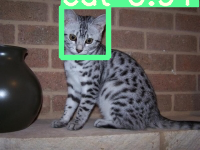

In [196]:
#U can check the path on the output of above.
#In this case, I can check the path on
# "Results saved to runs/detect/exp6"
Image(os.path.join('/yolov5/runs/detect/exp7', os.path.basename(val_img)))